C:\Users\honey\extracted_images
  DIR: Faces
  DIR: ftest
  DIR: Original Images
  FILE: Dataset.csv
C:\Users\honey\extracted_images\Faces
  DIR: Faces
C:\Users\honey\extracted_images\Faces\Faces
  FILE: Akshay Kumar_0.jpg
  FILE: Akshay Kumar_1.jpg
  FILE: Akshay Kumar_10.jpg
  FILE: Akshay Kumar_11.jpg
  FILE: Akshay Kumar_12.jpg
  FILE: Akshay Kumar_13.jpg
  FILE: Akshay Kumar_14.jpg
  FILE: Akshay Kumar_15.jpg
  FILE: Akshay Kumar_16.jpg
  FILE: Akshay Kumar_17.jpg
  FILE: Akshay Kumar_18.jpg
  FILE: Akshay Kumar_19.jpg
  FILE: Akshay Kumar_2.jpg
  FILE: Akshay Kumar_20.jpg
  FILE: Akshay Kumar_21.jpg
  FILE: Akshay Kumar_22.jpg
  FILE: Akshay Kumar_23.jpg
  FILE: Akshay Kumar_24.jpg
  FILE: Akshay Kumar_25.jpg
  FILE: Akshay Kumar_26.jpg
  FILE: Akshay Kumar_27.jpg
  FILE: Akshay Kumar_28.jpg
  FILE: Akshay Kumar_29.jpg
  FILE: Akshay Kumar_3.jpg
  FILE: Akshay Kumar_30.jpg
  FILE: Akshay Kumar_31.jpg
  FILE: Akshay Kumar_32.jpg
  FILE: Akshay Kumar_33.jpg
  FILE: Akshay Kumar_34.

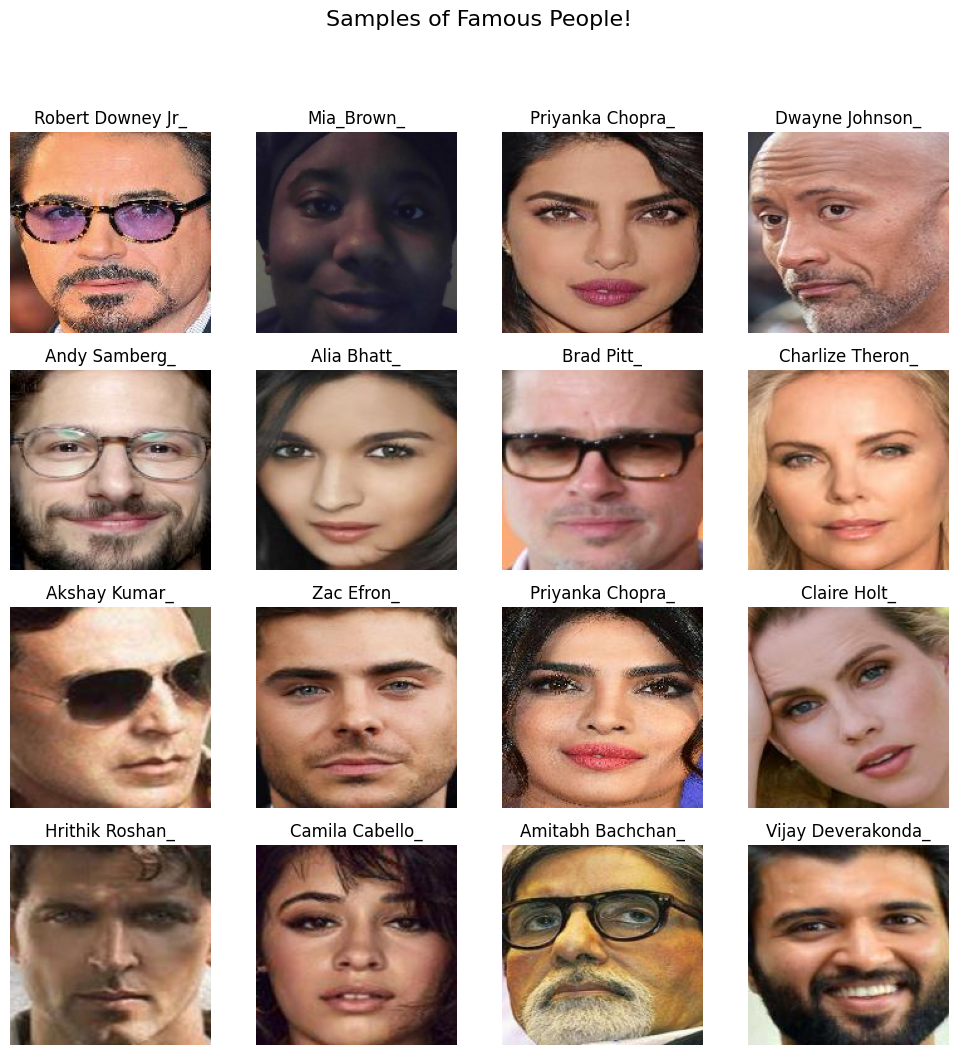

100%|████████████████████████████████████████████████████████████| 2636/2636 [50:23<00:00,  1.15s/it]


                     precision    recall  f1-score   support

      Akshay Kumar_       0.91      1.00      0.95        10
Alexandra Daddario_       1.00      1.00      1.00        18
        Alia Bhatt_       1.00      1.00      1.00        16
  Amitabh Bachchan_       1.00      1.00      1.00        15
      Andy Samberg_       1.00      1.00      1.00        18
    Anushka Sharma_       1.00      1.00      1.00        14
     Billie Eilish_       0.95      0.90      0.92        20
         Brad Pitt_       0.96      1.00      0.98        24
    Camila Cabello_       1.00      1.00      1.00        17
   Charlize Theron_       1.00      1.00      1.00        16
       Claire Holt_       0.95      1.00      0.97        19
      Courtney Cox_       1.00      1.00      1.00        16
    Dwayne Johnson_       1.00      1.00      1.00        12
   Elizabeth Olsen_       1.00      1.00      1.00        14
   Ellen Degeneres_       1.00      1.00      1.00        15
      Henry Cavill_    

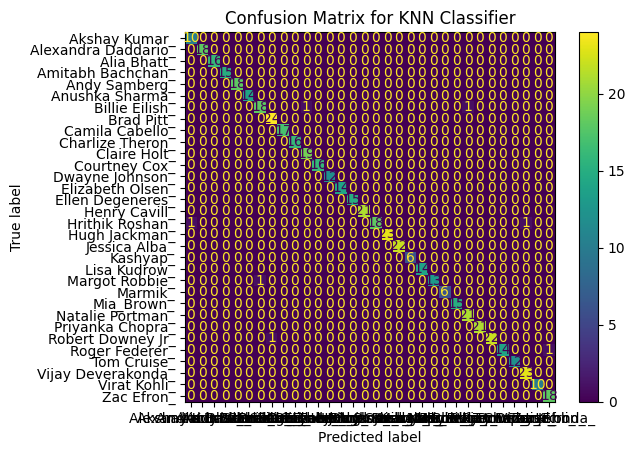

Face at location (76, 418, 461, 33) is recognized as: Alia Bhatt_


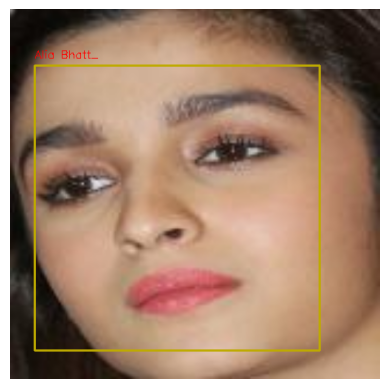

In [12]:
import face_recognition
import glob
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import os
from tqdm import tqdm
import seaborn as sns
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from face_recognition.face_recognition_cli import image_files_in_folder
import cv2
import pandas as pd
import zipfile
import pickle
import random

# Paths
zip_file_path = r'C:\Users\honey\Downloads\archive.zip'  # Path to the ZIP file
extract_dir = r'C:\Users\honey\extracted_images'  # Destination directory for extracted files

# Extract ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Debugging: Print extracted files and directories
for root, dirs, files in os.walk(extract_dir):
    print(root)
    for name in dirs:
        print(f"  DIR: {name}")
    for name in files:
        print(f"  FILE: {name}")

# Update path to the folder where faces are located inside the ZIP
dirpath = os.path.join(extract_dir, 'Faces', 'Faces')  # Path to extracted Faces folder
if not os.path.exists(dirpath):
    raise FileNotFoundError(f"Directory not found: {dirpath}")
    
def extract_label_from_filename(filename):
    # Assuming filename structure: "firstname lastname_#.jpg"
    # Split by '_' and take the first part for "firstname lastname"
    return os.path.basename(filename).split('_')[0]    

# Create dataset function
def create_dataset(dirpath):
    images = list(Path(dirpath).glob('*.jpg'))  # Directly in Faces folder
    labels = [img.name.split('.')[0].rstrip('0123456789') for img in images]  # Extract base names as labels
    print(f"Unique labels: {len(set(labels))}")  # Debugging: Unique labels
    print(f"Total images: {len(images)}")  # Debugging: Total number of images
    return images, labels

# Create dataset
images, labels = create_dataset(dirpath)

# Shuffle images and labels randomly
combined = list(zip(images, labels))
random.shuffle(combined)

# Select 1/3 of the images
num_images_to_process = len(images) // 3
images_to_process, labels_to_process = zip(*combined[:num_images_to_process])

# Show samples
def show_samples(images, labels):
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                             subplot_kw={'xticks': [], 'yticks': []})
    plt.suptitle('Samples of Famous People!', y=1.05, fontsize=16)

    for i, ax in enumerate(axes.flat):
        index = np.random.randint(0, len(images))
        img = cv2.imread(str(images[index]))
        rgbimg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(rgbimg)
        ax.set_title(labels[index])
        ax.set_axis_off()
    plt.tight_layout()
    plt.show()

# Visualize Samples
show_samples(images, labels)

# Process Images and Encode Faces
X, y = [], []
for img_path, label in tqdm(zip(images, labels), total=len(images)):
    img = face_recognition.load_image_file(img_path)
    img = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Using CNN over Default h0g for better accuracy
    # img_rgb_resized = cv2.resize(img_rgb, (0, 0), fx=0.7, fy=0.7)
    face_locations = face_recognition.face_locations(img_rgb, model='hog')
    if len(face_locations) == 0:
        face_locations = face_recognition.face_locations(img_rgb, model='cnn')
    # face_locations = face_recognition.face_locations(img_rgb, model='cnn')
    if len(face_locations) == 1:  # Only process images with a single face
        face_encoding = face_recognition.face_encodings(img_rgb, known_face_locations=face_locations)[0]
        X.append(face_encoding)
        y.append(label)
    else:
        print(f"Skipping {img_path} - {len(face_locations)} faces detected")

if len(X) == 0:
    raise ValueError("No valid images with single faces were found. Please verify your dataset.")

# Train-Test Split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train Classifier
model = KNeighborsClassifier(n_neighbors=2, weights='distance')
model.fit(x_train, y_train)

# Save the trained KNN model
with open("C:/Users/honey/Desktop/Website/knn_model.pkl", "wb") as model_file:
    pickle.dump(model, model_file)
# Save the label names
with open("C:/Users/honey/Desktop/Website/labels.pkl", "wb") as labels_file:
    pickle.dump(y, labels_file)

# Predict and Evaluate
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot()
plt.title("Confusion Matrix for KNN Classifier")
plt.show()

# Test Recognition on New Images
index = np.random.randint(0, len(images))
test_image = face_recognition.load_image_file(images[index])
resized_image = cv2.resize(test_image, (500, 500))

# Get face locations and encodings
locations = face_recognition.face_locations(resized_image)
encodings = face_recognition.face_encodings(resized_image, locations)

# Check if any faces were found
if len(encodings) > 0:  # Ensure encodings are found
    # Convert to a 2D array for the model
    encodings = np.array(encodings)

    # Initialize the threshold for matching
    threshold = 0.6

    # Get closest distances
    distances = model.kneighbors(encodings, n_neighbors=1, return_distance=True)

    # Determine matches based on threshold
    all_matches = [distances[0][i][0] <= threshold for i in range(len(distances[0]))]

    # Go through all the face locations and predict names of the matched face
    for i in range(len(locations)):
        if all_matches[i]:
            name = model.predict([encodings[i]])[0]
        else:
            name = 'unknown'
        print(f"Face at location {locations[i]} is recognized as: {name}")
        

    # Annotate the image
    for (top, right, bottom, left), match in zip(locations, all_matches):
    # Determine the name based on the match
        if match:
            name = model.predict([encodings[locations.index((top, right, bottom, left))]])[0]
        else:
            name = 'unknown'
    
    # Draw rectangle and text
    cv2.rectangle(resized_image, (left, top), (right, bottom), (190, 170, 0), 2)
    cv2.putText(resized_image, name, (left, top - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)


    # Display the annotated image
    plt.imshow(resized_image)
    plt.axis('off')
    plt.show()
else:
    print("No faces found in the image.")
